In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

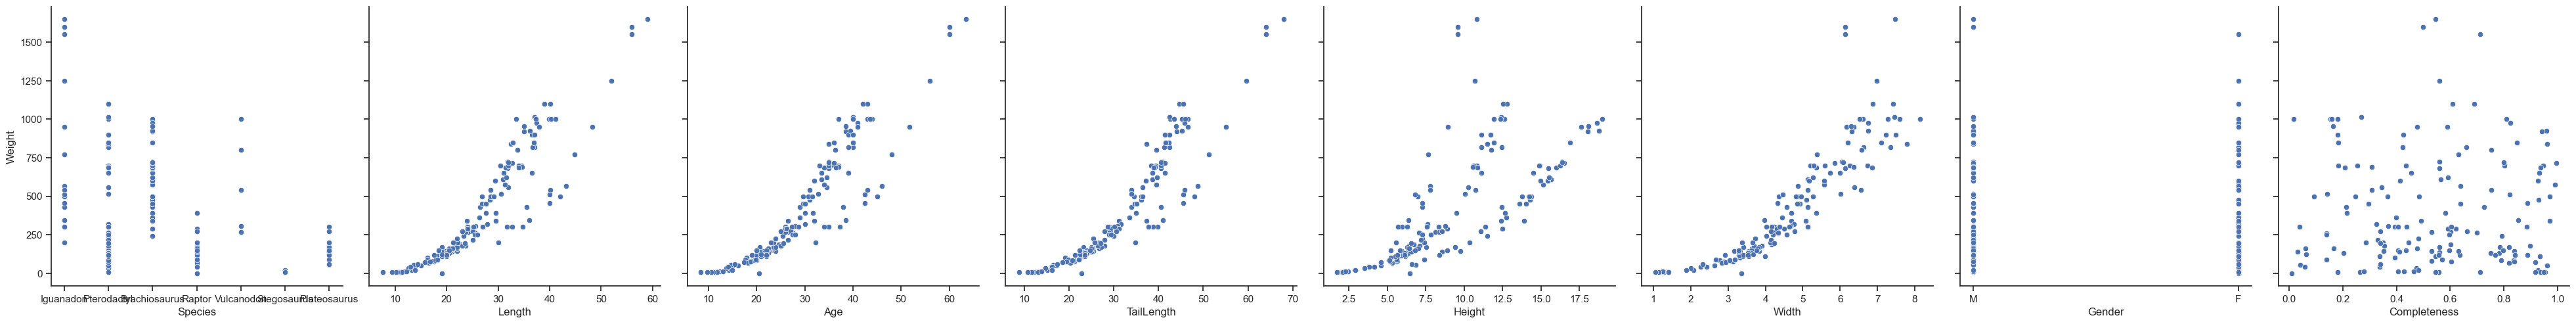

In [132]:
def plotdata(file):
    df = pd.read_csv(file)

    target = 'Weight'
    features = [col for col in df.columns if col != target]

    sns.set(style="ticks")
    sns.pairplot(df, x_vars=features, y_vars=target, height=5, aspect=1)
    plt.show()

datafile = 'dinos.csv'
plotdata(datafile)

In [133]:
# a lot of these look vaguely quadratic so I'm gonna do polynomial regression in the second degree
# also, I've made all the polynomical relations of the form y=ax^2+c instead of y=ax^2+bx+c
# I averaged a set of about 2000 iterations doing both of these, and the former resulted in like a 2% accuracy gain, not sure why but it is what it is

In [134]:
def datasplit(file):
    with open(file, 'r') as dataset:
        lines = dataset.readlines()
    header = lines[0]
    lines = lines[1:]

    random.shuffle(lines)
    split_index = int(0.7 * len(lines))
    training_set = lines[:split_index]
    testing_set = lines[split_index:]

    trainfile = 'train_dinos.csv'
    testfile = 'test_dinos.csv'
    with open(trainfile, 'w') as file1:
        file1.write(header)
        file1.writelines(training_set)
    with open(testfile, 'w') as file2:
        file2.write(header)
        file2.writelines(testing_set)

    return trainfile, testfile
training_file, testing_file = datasplit(datafile)

In [135]:
def readdata(file):
    df = pd.read_csv(file)
    return df

In [136]:
train_df = readdata(training_file)
train_df

,Species,Weight,Length,Age,TailLength,Height,Width,Gender,Completeness
0,Pterodactyl,1100.0,40.1,43.0,45.5,12.5125,7.4165,F,0.608
1,Plateosaurus,150.0,18.4,20.0,22.4,8.8928,3.2928,M,0.797
2,Iguanadon,1650.0,59.0,63.4,68.0,10.8120,7.4800,M,0.545
3,Raptor,40.0,12.9,14.1,16.2,4.1472,2.2680,F,0.058
4,Plateosaurus,273.0,23.0,25.0,28.0,11.0880,4.1440,F,0.341
...,...,...,...,...,...,...,...,...,...
106,Vulcanodon,306.0,25.6,28.0,30.8,8.7780,4.6816,M,0.370
107,Pterodactyl,145.0,20.7,22.7,24.2,5.9532,3.6300,M,0.353
108,Stegosaurus,6.7,9.3,9.8,10.8,1.7388,1.0476,F,0.546
109,Raptor,140.0,21.0,22.5,25.0,6.5500,3.3250,F,0.031


In [137]:
def encode_data(df):
    species_stats = df.groupby(by='Species')['Weight'].agg(['mean', 'var']).reset_index()
    df = pd.merge(df, species_stats, on='Species', how='left')
    df.rename(columns={'mean': 'Species_Mean', 'var': 'Species_Variance'}, inplace=True)
    df = df.drop('Species', axis=1)

    df = pd.get_dummies(df, columns=['Gender'], prefix='Gender').astype(float)

    return df

In [138]:
train_df = encode_data(train_df)
train_df

,Weight,Length,Age,TailLength,Height,Width,Completeness,Species_Mean,Species_Variance,Gender_F,Gender_M
0,1100.0,40.1,43.0,45.5,12.5125,7.4165,0.608,398.087179,141047.799042,1.0,0.0
1,150.0,18.4,20.0,22.4,8.8928,3.2928,0.797,146.625000,4455.410714,0.0,1.0
2,1650.0,59.0,63.4,68.0,10.8120,7.4800,0.545,702.818182,297837.363636,0.0,1.0
3,40.0,12.9,14.1,16.2,4.1472,2.2680,0.058,159.600000,10119.400000,1.0,0.0
4,273.0,23.0,25.0,28.0,11.0880,4.1440,0.341,146.625000,4455.410714,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
106,306.0,25.6,28.0,30.8,8.7780,4.6816,0.370,525.333333,169305.333333,0.0,1.0
107,145.0,20.7,22.7,24.2,5.9532,3.6300,0.353,398.087179,141047.799042,0.0,1.0
108,6.7,9.3,9.8,10.8,1.7388,1.0476,0.546,11.050000,17.385714,1.0,0.0
109,140.0,21.0,22.5,25.0,6.5500,3.3250,0.031,159.600000,10119.400000,1.0,0.0


In [139]:
def quad_terms(df):
    for column in ['Length', 'Age', 'TailLength', 'Height', 'Width']:
        df[column] = df[column] ** 2
    return df

In [140]:
train_df = quad_terms(train_df)
train_df

,Weight,Length,Age,TailLength,Height,Width,Completeness,Species_Mean,Species_Variance,Gender_F,Gender_M
0,1100.0,1608.01,1849.00,2070.25,156.562656,55.004472,0.608,398.087179,141047.799042,1.0,0.0
1,150.0,338.56,400.00,501.76,79.081892,10.842532,0.797,146.625000,4455.410714,0.0,1.0
2,1650.0,3481.00,4019.56,4624.00,116.899344,55.950400,0.545,702.818182,297837.363636,0.0,1.0
3,40.0,166.41,198.81,262.44,17.199268,5.143824,0.058,159.600000,10119.400000,1.0,0.0
4,273.0,529.00,625.00,784.00,122.943744,17.172736,0.341,146.625000,4455.410714,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
106,306.0,655.36,784.00,948.64,77.053284,21.917379,0.370,525.333333,169305.333333,0.0,1.0
107,145.0,428.49,515.29,585.64,35.440590,13.176900,0.353,398.087179,141047.799042,0.0,1.0
108,6.7,86.49,96.04,116.64,3.023425,1.097466,0.546,11.050000,17.385714,1.0,0.0
109,140.0,441.00,506.25,625.00,42.902500,11.055625,0.031,159.600000,10119.400000,1.0,0.0


In [141]:
def featurescale(df):
    target_column = df['Weight']
    means = df.iloc[:, 1:].mean()
    standard_deviations = df.iloc[:, 1:].std()
    scaled_df = (df.iloc[:, 1:] - means) / standard_deviations
    features = scaled_df.to_numpy()
    scaled_df['Weight'] = target_column
    targets = target_column.to_numpy()
    return scaled_df, features, targets

In [142]:
train_df, x_train, y_train = featurescale(train_df)
train_df

,Length,Age,TailLength,Height,Width,Completeness,Species_Mean,Species_Variance,Gender_F,Gender_M,Weight
0,1.387298,1.361967,1.211284,0.617745,2.042531,0.315415,-0.036450,0.513157,1.119780,-1.119780,1100.0
1,-0.746380,-0.751997,-0.761758,-0.270624,-0.755826,0.979247,-1.231799,-1.016100,-0.884987,0.884987,150.0
2,4.535400,4.528623,4.423709,0.162978,2.102471,0.094137,1.412119,2.268538,-0.884987,0.884987,1650.0
3,-1.035728,-1.045516,-1.062805,-0.980149,-1.116930,-1.616373,-1.170121,-0.952688,1.119780,-1.119780,40.0
4,-0.426291,-0.423742,-0.406722,0.232281,-0.354708,-0.622381,-1.231799,-1.016100,1.119780,-1.119780,273.0
...,...,...,...,...,...,...,...,...,...,...,...
106,-0.213906,-0.191775,-0.199617,-0.293883,-0.054060,-0.520523,0.568427,0.829522,-0.884987,0.884987,306.0
107,-0.595227,-0.583799,-0.656244,-0.771000,-0.607907,-0.580232,-0.036450,0.513157,-0.884987,0.884987,145.0
108,-1.170057,-1.195448,-1.246210,-1.142685,-1.373331,0.097649,-1.876268,-1.065787,1.119780,-1.119780,6.7
109,-0.574200,-0.596988,-0.606732,-0.685445,-0.742324,-1.711206,-1.170121,-0.952688,1.119780,-1.119780,140.0


In [143]:
print(x_train)
print(y_train)

[[ 1.38729777  1.36196665  1.21128394 ...  0.51315718  1.11977987
  -1.11977987]
 [-0.74638047 -0.75199726 -0.76175824 ... -1.01610028 -0.88498732
   0.88498732]
 [ 4.5353997   4.52862332  4.42370893 ...  2.26853766 -0.88498732
   0.88498732]
 ...
 [-1.17005708 -1.19544824 -1.24621016 ... -1.0657874   1.11977987
  -1.11977987]
 [-0.5742004  -0.59698783 -0.60673161 ... -0.95268754  1.11977987
  -1.11977987]
 [ 0.35233482  0.40090818  0.58966792 ... -0.61148876 -0.88498732
   0.88498732]]
[1100.   150.  1650.    40.   273.   500.   260.  1000.   430.   600.
 1100.   270.    55.   450.   145.   685.   170.   514.  1550.   390.
  475.   120.   242.   340.     9.8  180.     0.   500.   950.   680.
  110.  1250.   390.   340.  1015.  1000.     9.9  610.    40.   430.
    7.   450.   500.    51.5  218.   955.  1000.   300.    32.   700.
  850.   300.     5.9   78.   100.   820.   714.   456.     9.7   13.4
  145.   200.   115.   150.   700.   600.   290.    80.   140.    69.
  160.    90.   8

In [144]:
def accuracy(features, targets, weights, bias):
    predictions = np.dot(features, weights) + bias
    residual_square_sum = np.sum((targets - predictions) ** 2)
    total_square_sum = np.sum((targets - np.mean(targets)) ** 2)
    r_squared = 1 - (residual_square_sum / total_square_sum)

    return r_squared

In [145]:
def gradient_descent(features, targets, learning_rate=0.01, epochs=500):
    bias = 0
    weights = np.zeros(features.shape[1])

    mean_square_errors = np.empty(epochs)
    r_squareds = np.empty(epochs)

    for iternum in range(epochs):
        errors = np.dot(features, weights) + bias - targets

        mean_square_errors[iternum] = (0.5 / len(features)) * np.sum(errors ** 2)
        r_squareds[iternum] = accuracy(features, targets, weights, bias)

        weight_gradient = (1 / len(features)) * np.dot(features.T, errors)
        bias_gradient = (1 / len(features)) * np.sum(errors)

        weights -= learning_rate * weight_gradient
        bias -= learning_rate * bias_gradient

    return weights, bias, mean_square_errors, r_squareds

In [146]:
w, b, mse, r2 = gradient_descent(x_train, y_train)
print(w)
print(b)

[ 79.01000428  79.86505736  74.99001532  72.95302332 115.64901075
   1.6491939  -22.94102451 -12.83545428   2.30597007  -2.30597007]
403.08894890404775


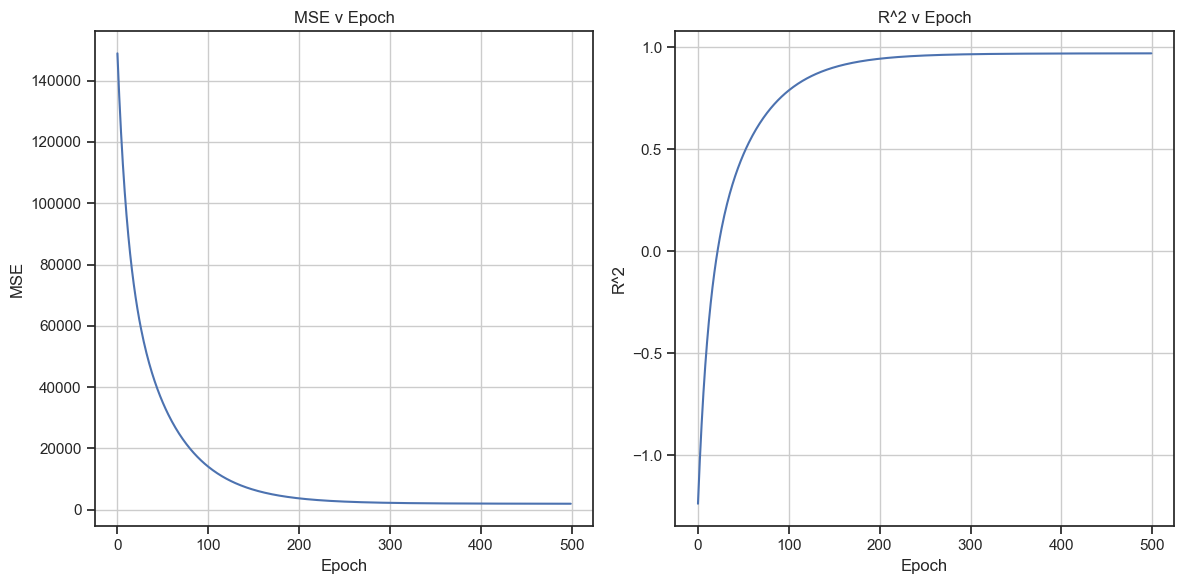

In [147]:
def graphing(mean_square_errors, r_squareds):
    epoch = range(len(mean_square_errors))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epoch, mean_square_errors)
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.title('MSE v Epoch')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epoch, r_squareds)
    plt.xlabel('Epoch')
    plt.ylabel('R^2')
    plt.title('R^2 v Epoch')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

graphing(mse, r2)

In [148]:
test_df = readdata(testing_file)
test_df

,Species,Weight,Length,Age,TailLength,Height,Width,Gender,Completeness
0,Raptor,169.0,22.0,24.0,27.2,7.5344,3.8352,F,0.819
1,Stegosaurus,7.5,10.0,10.5,11.6,1.9720,1.1600,M,0.712
2,Pterodactyl,150.0,21.0,23.0,24.5,5.2185,3.6260,F,0.406
3,Pterodactyl,180.0,23.0,25.0,26.5,6.4395,3.6835,F,0.354
4,Pterodactyl,120.0,20.0,22.0,23.5,5.6400,3.5250,M,0.769
5,Pterodactyl,130.0,20.5,22.5,24.0,5.8560,3.6240,M,0.204
6,Raptor,110.0,19.1,20.8,23.1,6.1677,3.3957,F,0.338
7,Iguanadon,540.0,40.1,43.0,45.8,7.7860,5.1296,F,0.753
8,Vulcanodon,800.0,33.7,36.4,39.6,11.7612,6.5736,F,0.753
9,Pterodactyl,650.0,36.5,39.0,41.4,11.1366,6.0030,M,0.931


In [149]:
test_df, x_test, y_test = featurescale(quad_terms(encode_data(test_df)))
test_df

,Length,Age,TailLength,Height,Width,Completeness,Species_Mean,Species_Variance,Gender_F,Gender_M,Weight
0,-0.513415,-0.508037,-0.457389,-0.386312,-0.466757,0.969914,-1.055194,-1.188176,1.075731,-1.075731,169.0
1,-1.135072,-1.165815,-1.199038,-1.008479,-1.407556,0.508880,-1.549997,-1.209807,-0.910234,0.910234,7.5
2,-0.583028,-0.574415,-0.628428,-0.733814,-0.576647,-0.809593,-0.147815,0.217691,1.075731,-1.075731,150.0
3,-0.440565,-0.438835,-0.503448,-0.566332,-0.547057,-1.033648,-0.147815,0.217691,1.075731,-1.075731,180.0
4,-0.649403,-0.637969,-0.687243,-0.679963,-0.627495,0.754477,-0.147815,0.217691,-0.910234,0.910234,120.0
5,-0.616620,-0.606545,-0.658142,-0.650746,-0.577668,-1.679958,-0.147815,0.217691,-0.910234,0.910234,130.0
6,-0.706372,-0.710504,-0.710082,-0.606650,-0.690495,-1.102587,-1.055194,-1.188176,1.075731,-1.075731,110.0
7,1.306243,1.289819,1.206323,-0.340959,0.350195,0.685538,1.536951,2.144014,1.075731,-1.075731,540.0
8,0.541605,0.549718,0.557552,0.573306,1.539956,0.685538,0.651852,0.069351,1.075731,-1.075731,800.0
9,0.859816,0.826585,0.736200,0.405029,1.034733,1.452493,-0.147815,0.217691,-0.910234,0.910234,650.0


In [150]:
print(x_test)
print(y_test)

[[-0.5134152  -0.50803719 -0.45738858 -0.38631214 -0.46675722  0.96991424
  -1.05519384 -1.18817572  1.0757309  -1.0757309 ]
 [-1.13507234 -1.16581543 -1.19903802 -1.00847881 -1.40755624  0.50887958
  -1.54999688 -1.20980652 -0.91023384  0.91023384]
 [-0.58302785 -0.57441524 -0.62842817 -0.73381405 -0.5766472  -0.80959338
  -0.14781455  0.21769105  1.0757309  -1.0757309 ]
 [-0.44056476 -0.43883454 -0.50344759 -0.56633204 -0.54705732 -1.03364761
  -0.14781455  0.21769105  1.0757309  -1.0757309 ]
 [-0.6494027  -0.63796869 -0.68724256 -0.67996279 -0.62749543  0.75447748
  -0.14781455  0.21769105 -0.91023384  0.91023384]
 [-0.61662    -0.60654504 -0.65814169 -0.65074624 -0.57766803 -1.67995789
  -0.14781455  0.21769105 -0.91023384  0.91023384]
 [-0.70637175 -0.71050437 -0.71008215 -0.60664982 -0.69049481 -1.10258737
  -1.05519384 -1.18817572  1.0757309  -1.0757309 ]
 [ 1.30624323  1.2898194   1.20632344 -0.34095881  0.35019532  0.68553772
   1.53695093  2.14401409  1.0757309  -1.0757309 ]


In [151]:
print(f'{accuracy(x_test, y_test, w, b) * 100}% accuracy')

95.5108476075974% accuracy


In [152]:
# It should be noted -- for some specific cases of test-train data split, the accuracy for the testing data returns 'NaN'.
# Why? I don't know, I couldn't fix it. I put a band-aid on in the raw python file by iterating the model over and over
# until it found a valid testing set. This seemed like a bad idea in a cell-based environment like the .ipynb
# So if you run this whole thing again and the output is NaN%, just do it again a couple times till you get a valid value.
# Sorry.